## Notebook file carrying out Utah, Alistair single cell RNA sample annotation

In [ ]:
!pip install --quiet scvi-tools[tutorials]
!pip install scanpy
!pip install anndata
!pip install --user scikit-misc

In [ ]:
import os
import tempfile
import scvi
import torch
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np
import scipy
from scipy.io import mmread

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
sc_raw_data_dir = "/content/drive/MyDrive/single_cell_genomics/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


obs column name and anndata field definition

In [ ]:
sample_col = "sample"
barcode_col = "barcode"
source_col = "source"
SCVI_LATENT_KEY = "X_scVI"
SCVI_MDE_KEY = "X_scVI_MDE"

In [ ]:
output_save_dir = '/content/drive/MyDrive/HGSOC_ATLAS/analysis_output/' + 'Utah_Alistair_scVI_integration_full_Utah/'
adata = ad.read_h5ad(output_save_dir + "integrate.adata")
model = scvi.model.SCVI.load(output_save_dir + "model", adata = adata)

INFO     File                                                                                                      
         /content/drive/MyDrive/HGSOC_ATLAS/analysis_output/Utah_Alistair_scVI_integration_full_Utah/model/model.pt
         already downloaded                                                                                        


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/scvi/model/base/_base_model.py:683: UserWarning: var_names for adata passed in does not match var_names of adata used to train the model. For valid results, the vars need to be the same and in the same order as the adata used to train the model.
  _validate_var_names(adata, var_names)


In [ ]:
adata.layers['scvi_normalized_scaled'] = sc.pp.scale(adata, layer='scvi_normalized', copy=True, zero_center=True).layers['scvi_normalized']
adata.layers['counts_normalize'] = sc.pp.normalize_total(adata, layer='counts', target_sum=1e4, copy=True).layers['counts']
adata.layers['counts_scale'] = sc.pp.scale(adata, layer='counts_normalize', copy=True, zero_center=True).layers['counts_normalize']

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
de_df = model.differential_expression(
    groupby="leiden",
)
de_df.head()

DE...: 100%|██████████| 19/19 [02:24<00:00,  7.58s/it]


proba_de  proba_not_de  bayes_factor        scale1        scale2  \
LILRB2     0.9884        0.0116      4.445082  6.183730e-09  1.556427e-06   
CLEC9A     0.9878        0.0122      4.394043  1.946874e-08  8.673343e-07   
EGFL6      0.9874        0.0126      4.361378  5.524010e-07  1.514447e-05   
ADCY9      0.9874        0.0126      4.361378  4.539136e-09  4.783143e-07   
IGLV3-1    0.9874        0.0126      4.361378  3.739687e-10  2.010317e-07   

         pseudocounts  delta  lfc_mean  lfc_median   lfc_std  ...  raw_mean1  \
LILRB2            0.0   0.25 -7.671794   -8.144813  4.624634  ...   0.000521   
CLEC9A            0.0   0.25 -5.846715   -6.269365  3.956003  ...   0.000000   
EGFL6             0.0   0.25 -6.922781   -7.541759  4.610498  ...   0.001736   
ADCY9             0.0   0.25 -8.598184   -9.771072  5.186264  ...   0.011109   
IGLV3-1           0.0   0.25 -6.908469   -6.654493  4.932638  ...   0.000694   

         raw_mean2  non_zeros_proportion1  non_zeros_proportion2  \
LILRB2    0.135528               0.000521               0.053341   
CLEC9A    0.008528               0.000000               0.003264   
EGFL6     0.111209               0.001736               0.064641   
ADCY9     0.394090               0.010588               0.093978   
IGLV3-1   0.011230               0.000521               0.004773   

         raw_normalized_mean1  raw_normalized_mean2  is_de_fdr_0.05  \
LILRB2               0.001844              0.223926            True   
CLEC9A               0.000000              0.015309            True   
EGFL6                0.013227              0.246264            True   
ADCY9                0.110623              0.536142            True   
IGLV3-1              0.003192              0.007112            True   

         comparison  group1 group2  
LILRB2    0 vs Rest       0   Rest  
CLEC9A    0 vs Rest       0   Rest  
EGFL6     0 vs Rest       0   Rest  
ADCY9     0 vs Rest       0   Rest  
IGLV3-1   0 vs Rest       0   Rest  

[5 rows x 22 columns]

In [ ]:
markers = {}
markers_top = {}
markers_top_5 = {}
cats = adata.obs.leiden.cat.categories
for i, c in enumerate(cats):
    cid = f"{c} vs Rest"
    cell_type_df = de_df.loc[de_df.comparison == cid]

    cell_type_df = cell_type_df[cell_type_df.lfc_mean >= 2]

    cell_type_df = cell_type_df[cell_type_df["bayes_factor"] >= 3]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion1"] >= 0.5]
    cell_type_df = cell_type_df[cell_type_df["non_zeros_proportion2"] <= 0.25]
    cell_type_df = cell_type_df.sort_values(by='bayes_factor', ascending=False)

    markers[c] = cell_type_df.index.tolist()
    markers_top[c] = cell_type_df.index.tolist()[:10]
    markers_top_5[c] = cell_type_df.index.tolist()[:5]

In [ ]:
for key, value in markers.items():
  print(key, ":", len(value))

0 : 1
1 : 1
2 : 41
3 : 159
4 : 7
5 : 34
6 : 0
7 : 16
8 : 44
9 : 77
10 : 17
11 : 12
12 : 220
13 : 11
14 : 159
15 : 37
16 : 14
17 : 42
18 : 44


In [ ]:
# prompt: add up the length of all values in markers

total_length = sum(len(value) for value in markers.values())
print(f"Total number of markers: {total_length}")


Total number of markers: 936


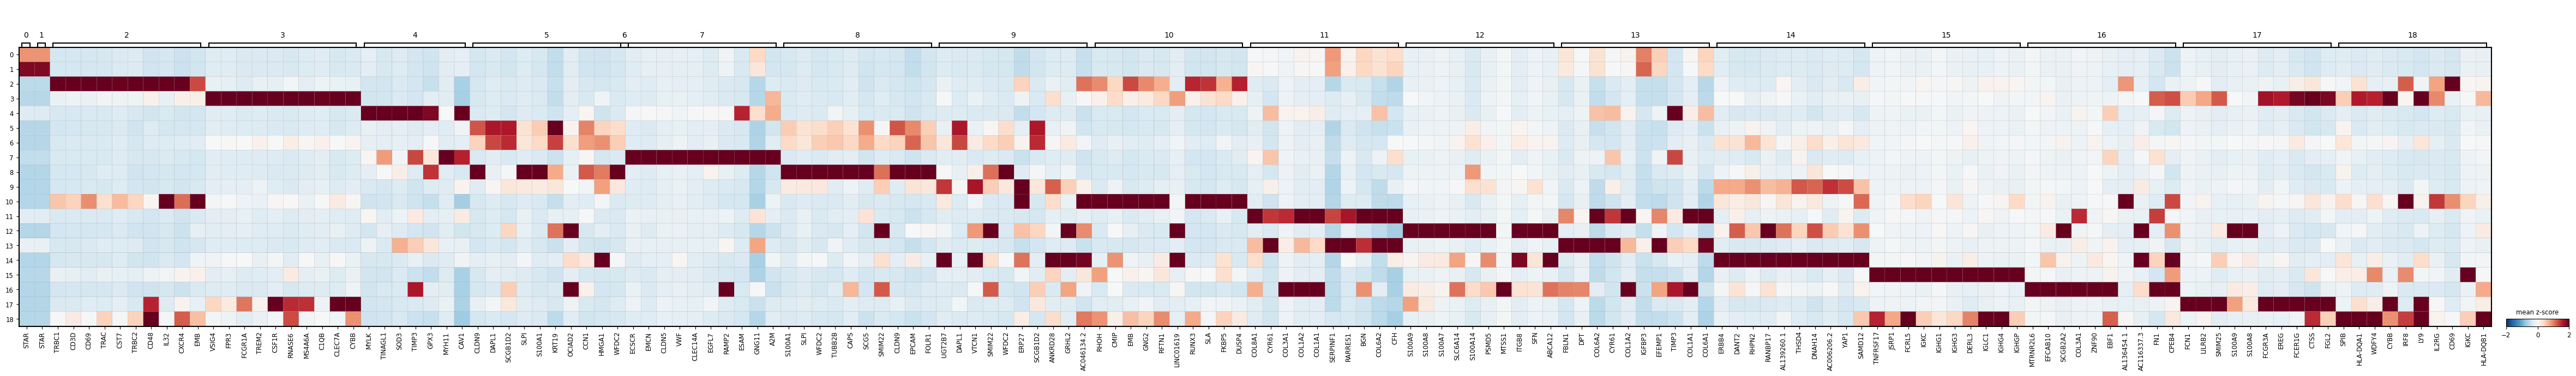

In [ ]:
# sc.pl.dotplot(
#     adata,
#     markers_top,
#     groupby="leiden",
#     layer='scvi_normalized',
#     dendrogram=False,
#     color_map="Blues",
#     swap_axes=False,
#     use_raw=False,
#     standard_scale="var",
# )

sc.pl.matrixplot(
    adata,
    markers_top,
    'leiden',
    dendrogram=False,
    layer='scvi_normalized_scaled',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

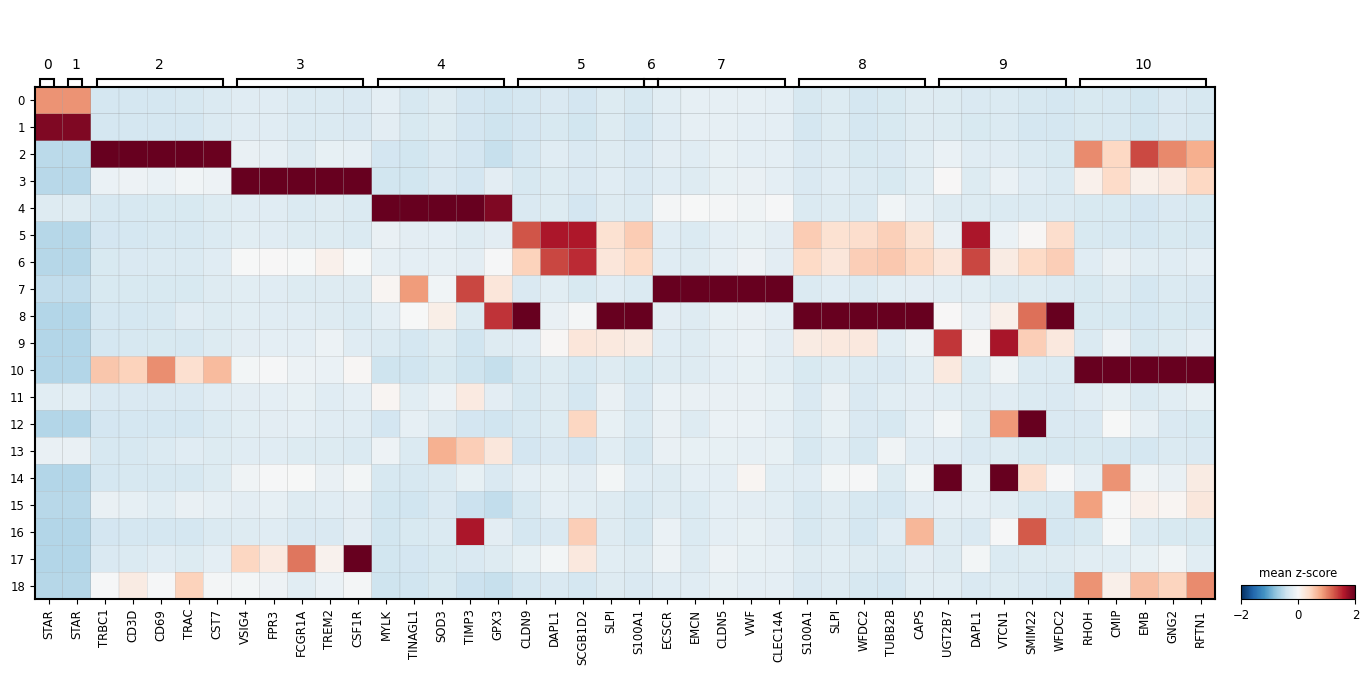

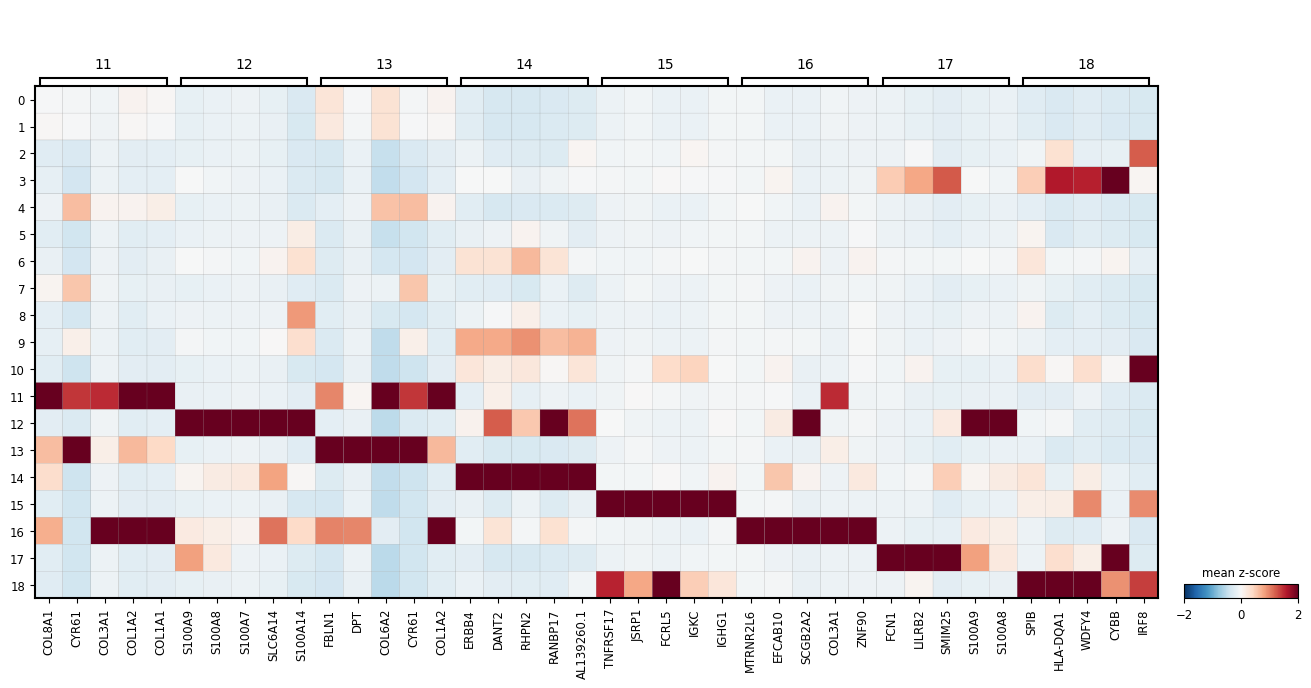

In [ ]:
markers_top_5_subset1 = {k: v for k, v in markers_top_5.items() if int(k) <= 10}
markers_top_5_subset2 = {k: v for k, v in markers_top_5.items() if int(k) > 10}

sc.pl.matrixplot(
    adata,
    markers_top_5_subset1,
    'leiden',
    dendrogram=False,
    layer='scvi_normalized_scaled',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

sc.pl.matrixplot(
    adata,
    markers_top_5_subset2,
    'leiden',
    dendrogram=False,
    layer='scvi_normalized_scaled',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

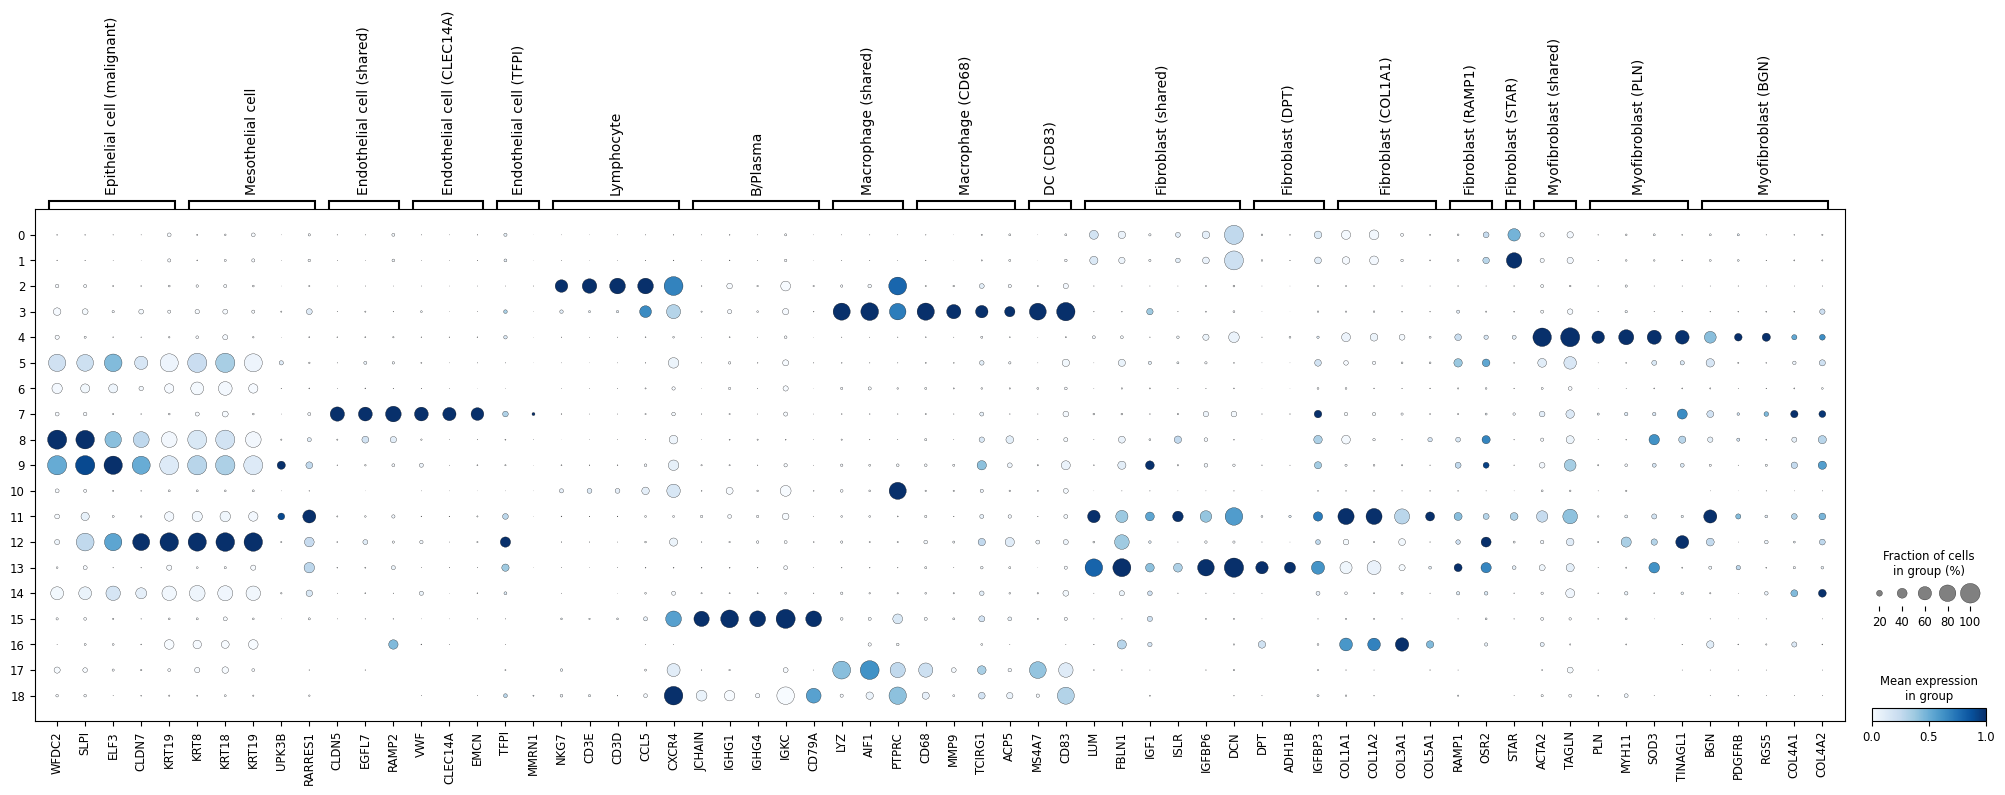

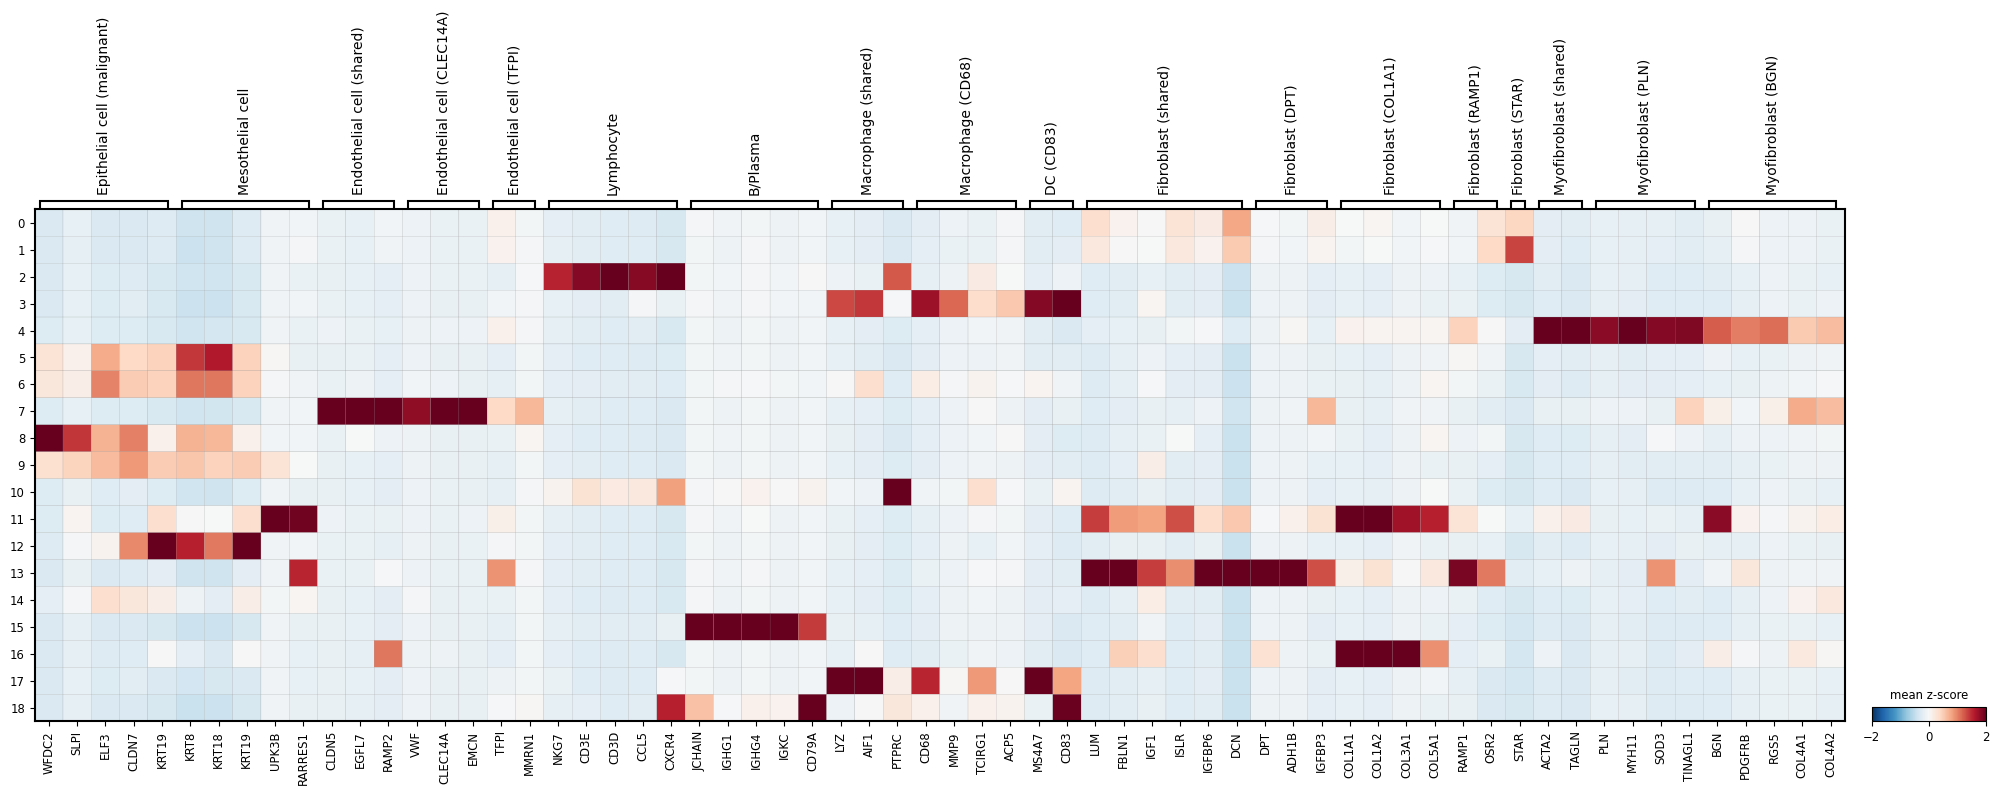

In [ ]:
marker_features = {
     "Epithelial cell (malignant)": ["WFDC2", "SLPI", "ELF3", "CLDN7", "KRT19"],
     "Mesothelial cell": ["KRT8", "KRT18", "KRT19", "UPK3B", "RARRES1"],
     "Endothelial cell (shared)": ["CLDN5", "EGFL7", "RAMP2"],
     "Endothelial cell (CLEC14A)": ["VWF", "CLEC14A", "EMCN"],
     "Endothelial cell (TFPI)": ["TFPI", "MMRN1"],
     "Lymphocyte": ["NKG7", "CD3E", "CD3D", "CCL5", "CXCR4"],
     "B/Plasma": ["JCHAIN", "IGHG1", "IGHG4", "IGKC", "CD79A"],
     "Macrophage (shared)": ["LYZ", "AIF1", "PTPRC"],
     "Macrophage (CD68)": ["CD68", "MMP9", "TCIRG1", "ACP5"],
     "DC (CD83)": ["MS4A7", "CD83"],
     "Fibroblast (shared)": ["LUM", "FBLN1", "IGF1", "ISLR", "IGFBP6", "DCN"],
     "Fibroblast (DPT)": ["DPT", "ADH1B", "IGFBP3"],
     "Fibroblast (COL1A1)": ["COL1A1", "COL1A2", "COL3A1", "COL5A1"],
     "Fibroblast (RAMP1)": ["RAMP1", "OSR2"],
     "Fibroblast (STAR)": ["STAR"],
     "Myofibroblast (shared)": ["ACTA2", "TAGLN"],
     "Myofibroblast (PLN)": ["PLN", "MYH11", "SOD3", "TINAGL1"],
     "Myofibroblast (BGN)": ["BGN", "PDGFRB", "RGS5", "COL4A1", "COL4A2"]
     }

sc.pl.dotplot(
    adata,
    marker_features,
    groupby="leiden",
    layer='counts',
    dendrogram=False,
    color_map="Blues",
    swap_axes=False,
    use_raw=False,
    standard_scale="var",
)
sc.pl.matrixplot(
    adata,
    marker_features,
    'leiden',
    dendrogram=False,
    layer='counts_scale',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

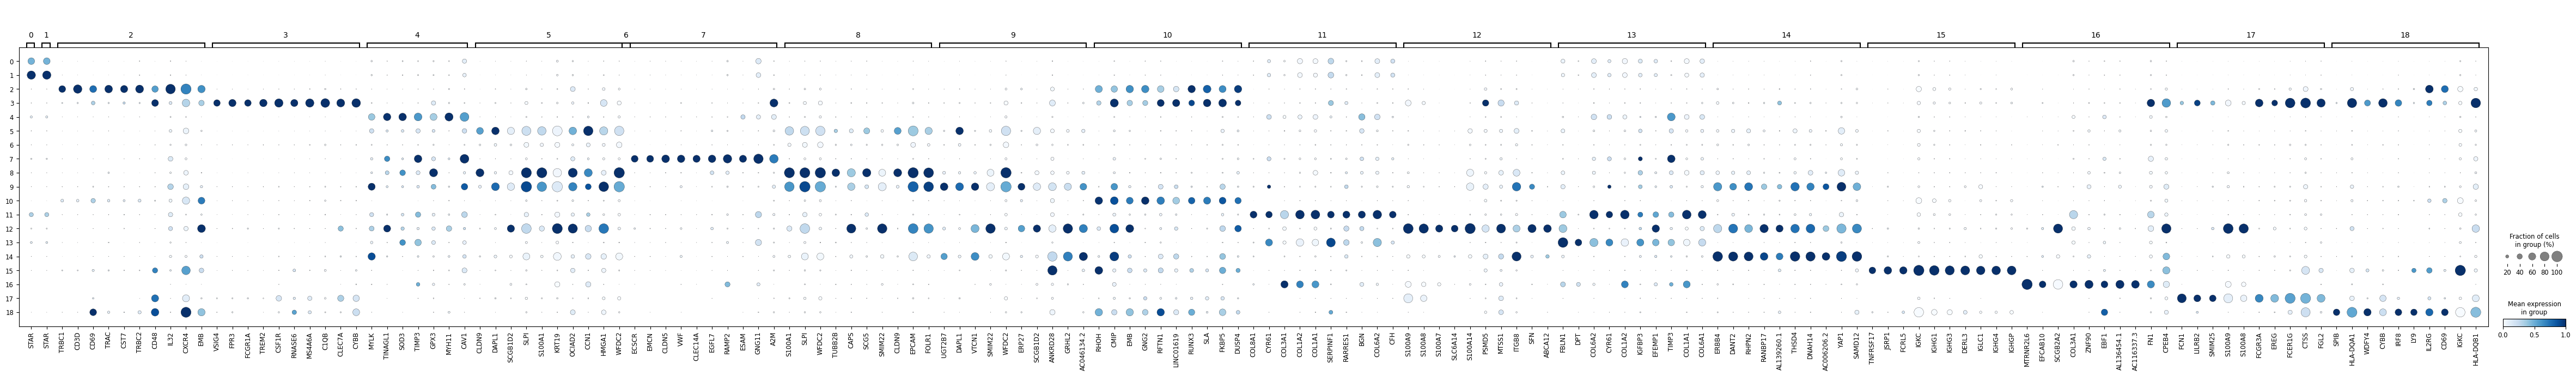

In [ ]:
sc.pl.dotplot(
    adata,
    markers_top,
    groupby="leiden",
    layer='counts',
    dendrogram=False,
    color_map="Blues",
    swap_axes=False,
    use_raw=False,
    standard_scale="var",
)
adata.obs['leiden_order'] = adata.obs['leiden']
adata.obs['leiden_order'] = adata.obs['leiden_order'].cat.reorder_categories(
    ['5', '6', '8', '9', '12', '14',
     '7',
     '2', '10', '15', '3', '17', '18',
     '13', '11', '16',
     '0', '1',
     '4']
    )

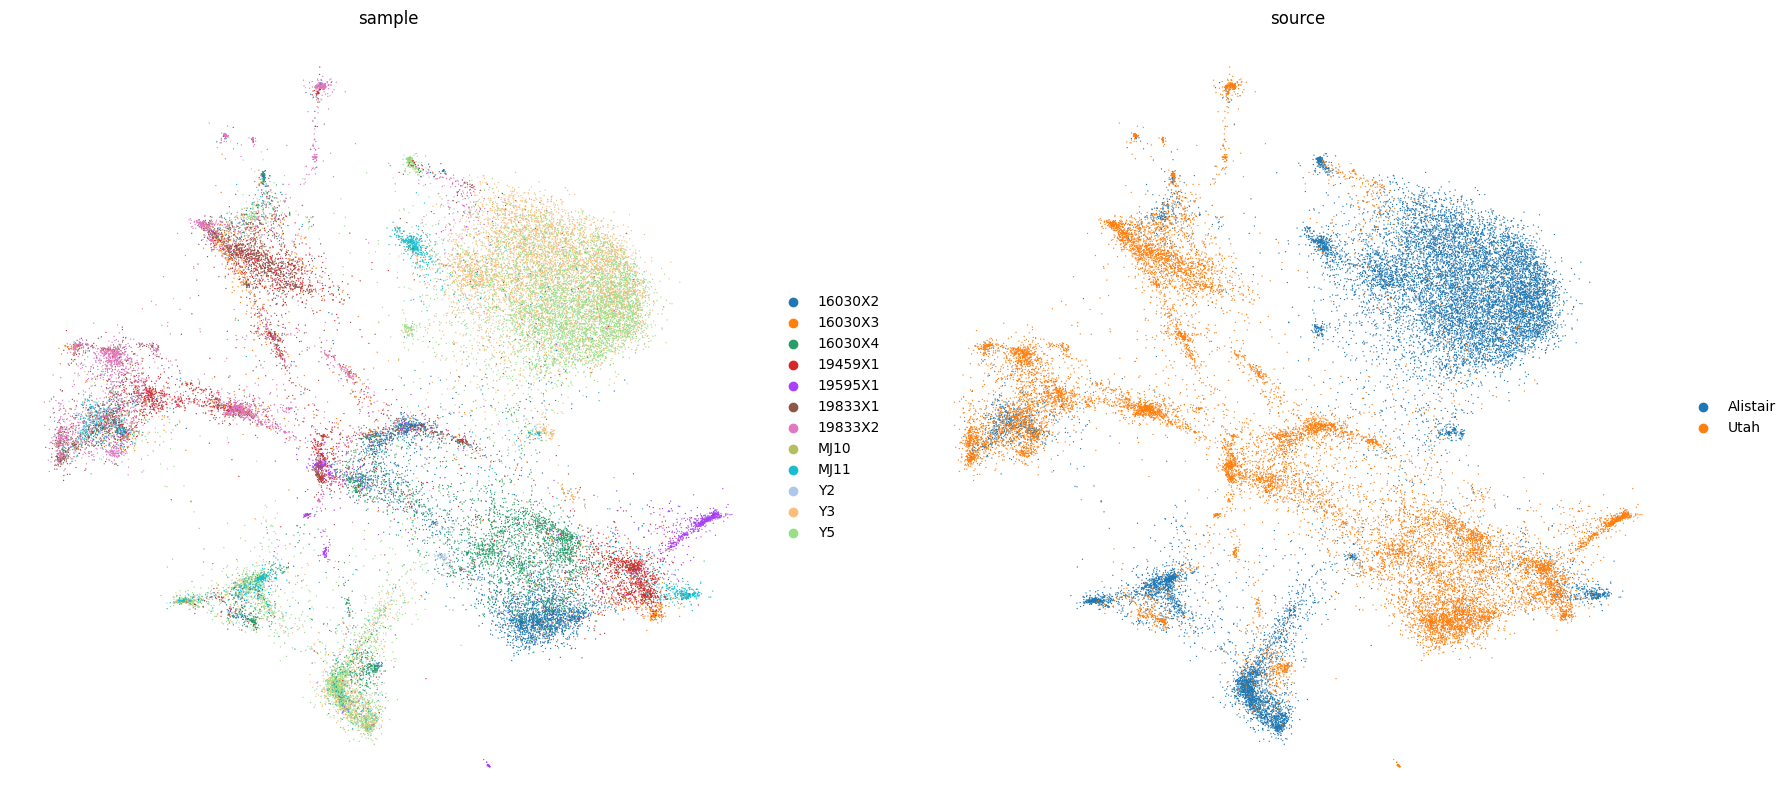

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.embedding(
      adata,
      basis=SCVI_MDE_KEY,
      color=[sample_col, source_col],
      frameon=False,
      ncols=2,
      add_outline=False
  )

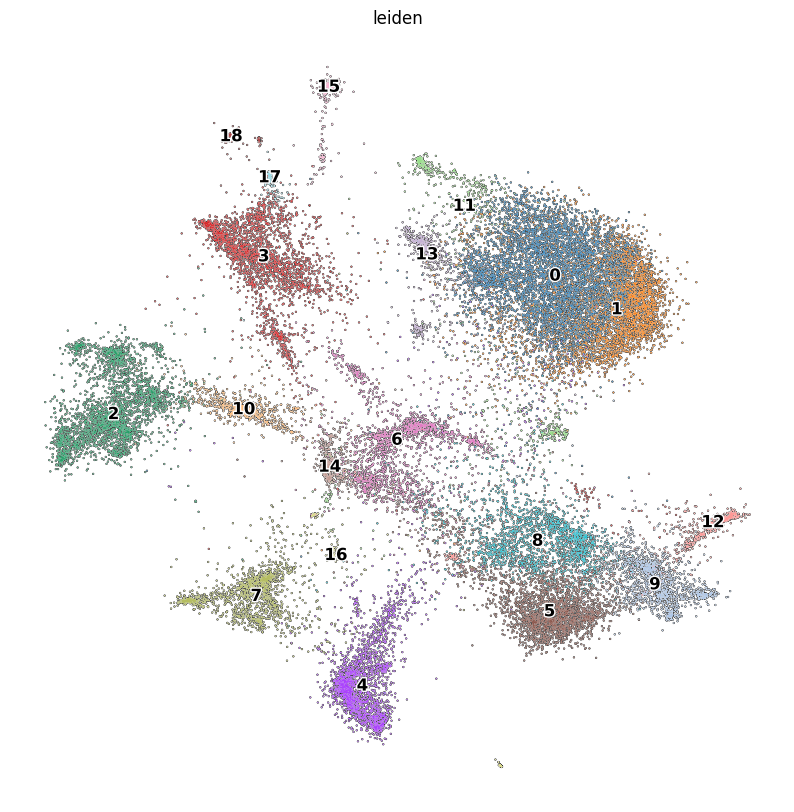

In [ ]:
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color='leiden', add_outline=True, legend_loc='on data',
                legend_fontsize=12, legend_fontoutline=2, frameon=False)

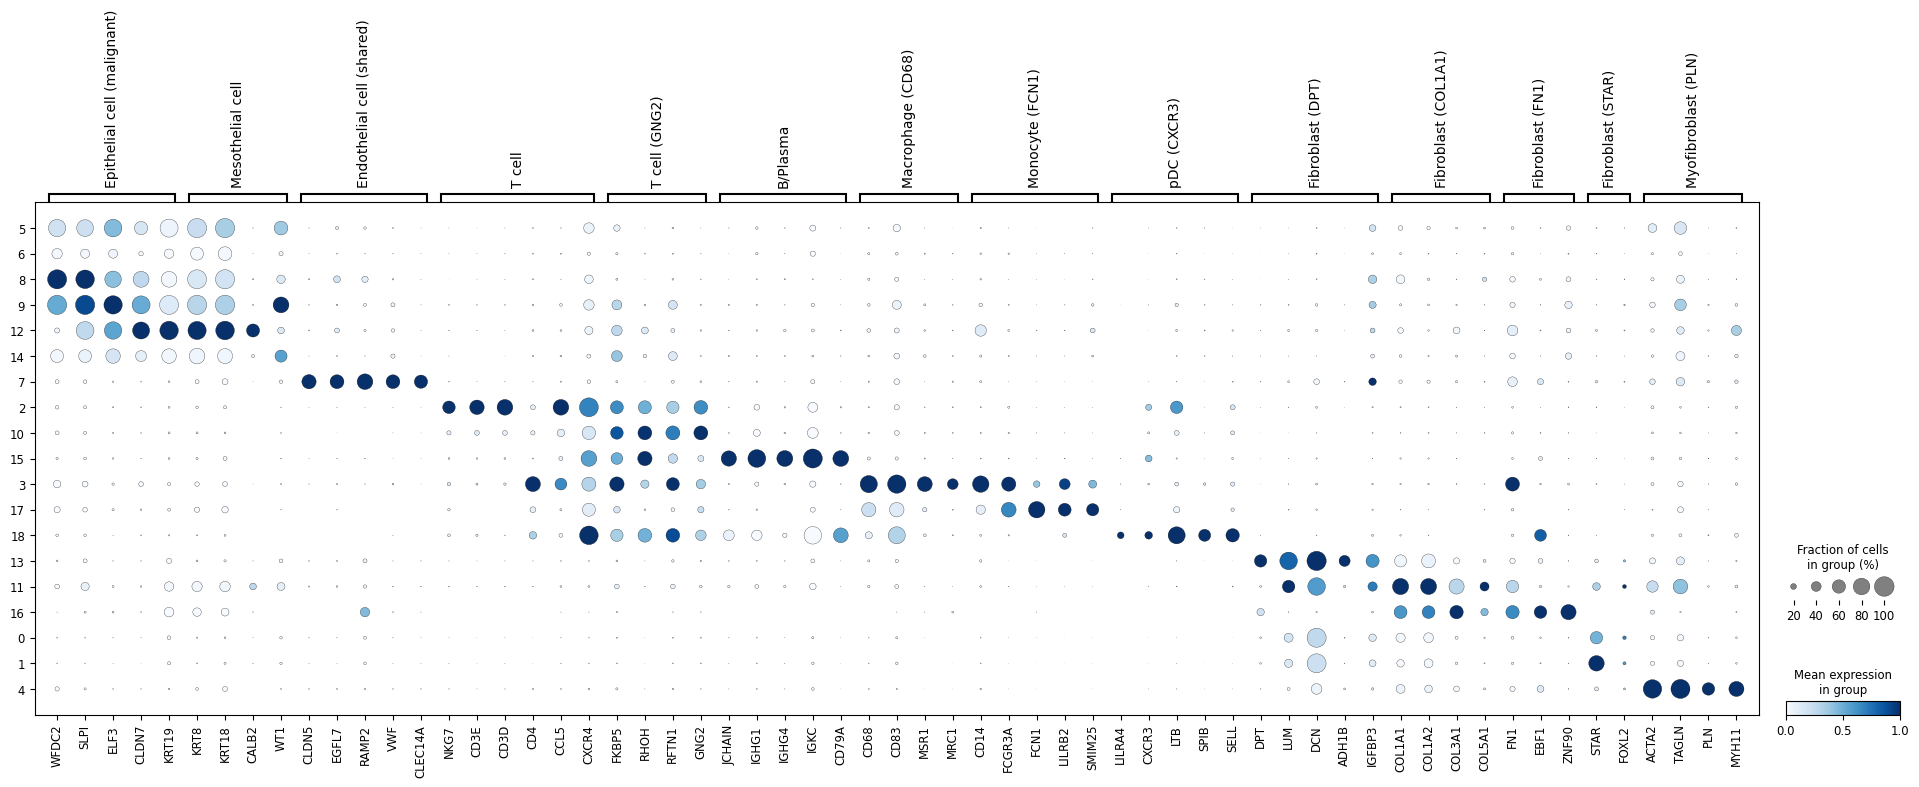

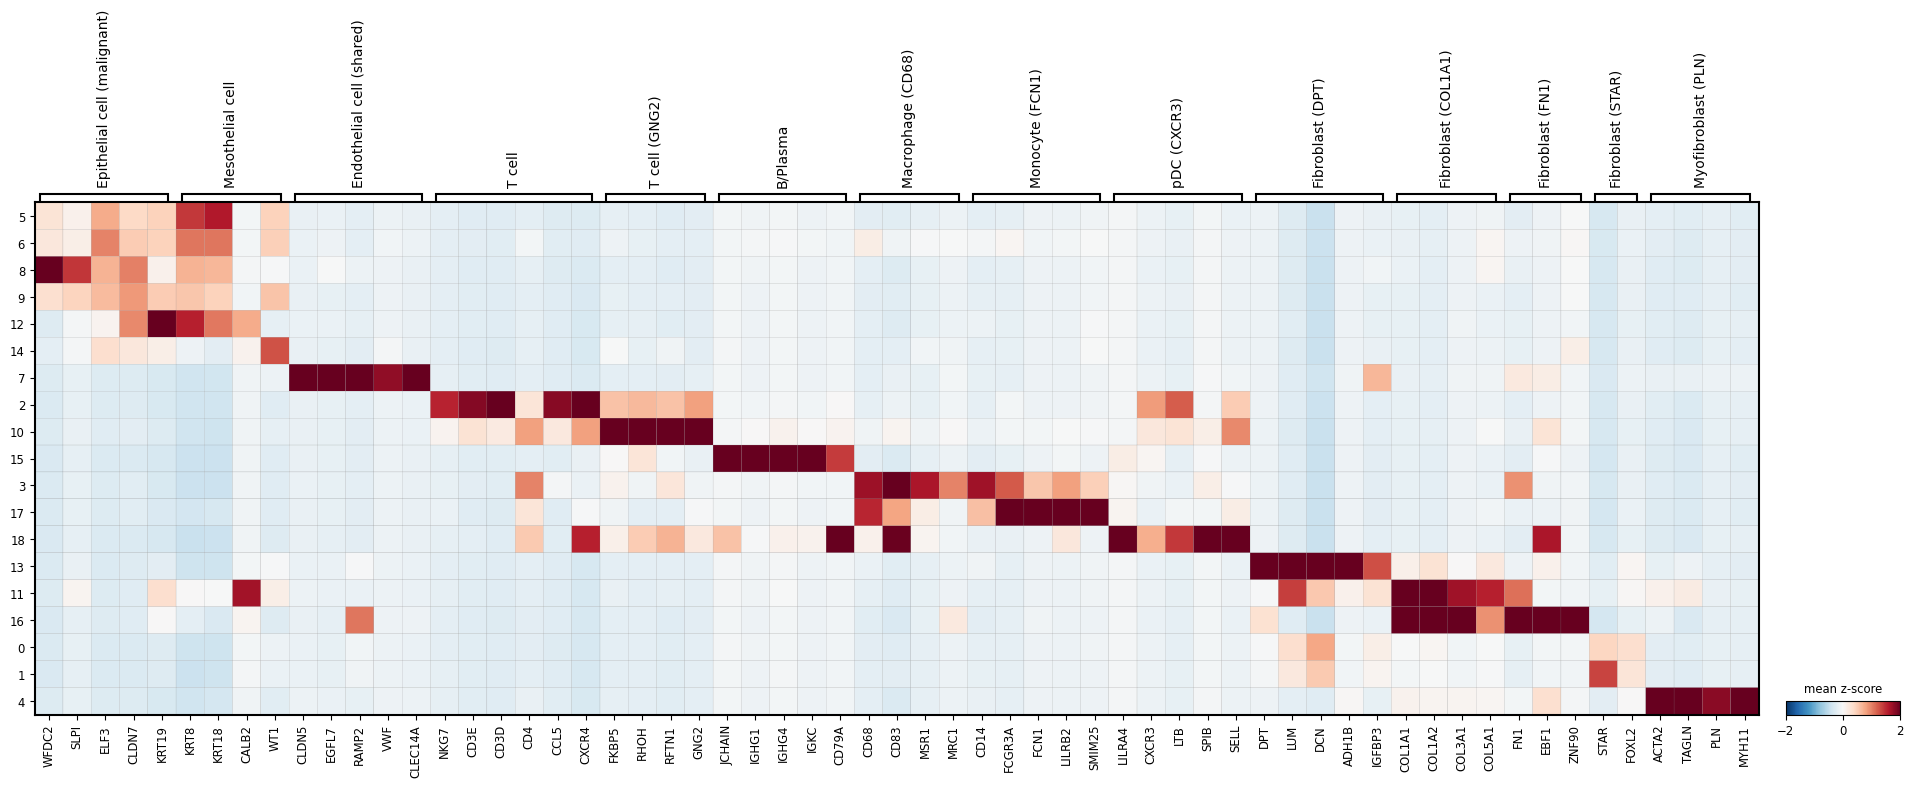

In [ ]:
marker_features = {
     "Epithelial cell (malignant)": ["WFDC2", "SLPI", "ELF3", "CLDN7", "KRT19"],
     "Mesothelial cell": ["KRT8", "KRT18", "CALB2", "WT1"],
     "Endothelial cell (shared)": ["CLDN5", "EGFL7", "RAMP2", "VWF", "CLEC14A"],
     "T cell": ["NKG7", "CD3E", "CD3D", "CD4", "CCL5", "CXCR4"],
     "T cell (GNG2)": ["FKBP5", "RHOH", "RFTN1", "GNG2"],
     "B/Plasma": ["JCHAIN", "IGHG1", "IGHG4", "IGKC", "CD79A"],
     "Macrophage (CD68)": ["CD68", "CD83", "MSR1", "MRC1"],
     "Monocyte (FCN1)": ["CD14", "FCGR3A", "FCN1", "LILRB2", "SMIM25"],
     "pDC (CXCR3)": ["LILRA4", "CXCR3", "LTB", "SPIB", "SELL"],
     # "Fibroblast (shared)": ["FBLN1", "IGF1", "ISLR", "IGFBP6", "DCN"],
     "Fibroblast (DPT)": ["DPT", "LUM", "DCN", "ADH1B", "IGFBP3"],
     "Fibroblast (COL1A1)": ["COL1A1", "COL1A2", "COL3A1", "COL5A1"],
     "Fibroblast (FN1)": ["FN1", "EBF1", "ZNF90"],
     "Fibroblast (STAR)": ["STAR", "FOXL2"],
     "Myofibroblast (PLN)": ["ACTA2", "TAGLN", "PLN", "MYH11"],
     }

sc.pl.dotplot(
    adata,
    marker_features,
    groupby="leiden_order",
    layer='counts',
    dendrogram=False,
    color_map="Blues",
    swap_axes=False,
    use_raw=False,
    standard_scale="var",
)

sc.pl.matrixplot(
    adata,
    marker_features,
    'leiden_order',
    dendrogram=False,
    layer='counts_scale',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

In [ ]:
annotation_dict = {
    "5": "Epithelial(WFDC2)",
    "6": "Epithelial(WFDC2)",
    "8": "Epithelial(WFDC2)",
    "9": "Epithelial(WFDC2)",
    "12": "Mesothelial(KRT8)",
    "14": "Epithelial(WFDC2)",
    "7": "Endothelial(CLEC14A)",
    "2": "T Lymphocyte(NKG7)",
    "10": "T Lymphocyte(IGNG2)",
    "15": "Plasmablast",
    "3": "Macrophage",
    "17": "Monocyte(FCN1)",
    "18": "pDC(CXCR3)",
    "13": "Fibroblast(DPT)",
    "11": "Fibroblast(COL1A1)",
    "16": "Fibroblast(FN1)",
    "0": "Fibroblast(STAR)",
    "1": "Fibroblast(STAR)",
    "4": "Myofibroblast(PLN)",
}
annotation_order = [
    "Epithelial(WFDC2)", "Mesothelial(KRT8)", "Endothelial(CLEC14A)",
    "T Lymphocyte(NKG7)", "T Lymphocyte(IGNG2)", "Plasmablast",
    "Macrophage", "Monocyte(FCN1)", "pDC(CXCR3)",
    "Fibroblast(DPT)", "Fibroblast(COL1A1)", "Fibroblast(FN1)", "Fibroblast(STAR)", "Myofibroblast(PLN)"]
adata.obs['marker_annotation'] = [annotation_dict[lei] for lei in adata.obs['leiden']]
adata.obs.marker_annotation = adata.obs.marker_annotation.astype("category")
adata.obs.marker_annotation = adata.obs.marker_annotation.cat.set_categories(annotation_order)


In [ ]:
adata.obs

sample    source             barcode  n_genes  \
AAACGGGTCACTCTTA_3       Y2  Alistair  AAACGGGTCACTCTTA_3     1858   
AAAGCAAGTGCAACTT_3       Y2  Alistair  AAAGCAAGTGCAACTT_3     1376   
AAAGTAGCAGGTTTCA_3       Y2  Alistair  AAAGTAGCAGGTTTCA_3      525   
AACACGTTCCATTCTA_3       Y2  Alistair  AACACGTTCCATTCTA_3     2397   
AACCATGAGGGCACTA_3       Y2  Alistair  AACCATGAGGGCACTA_3      808   
...                     ...       ...                 ...      ...   
TTTGGTTAGGAGATAG-1  19833X2      Utah  TTTGGTTAGGAGATAG-1     1667   
TTTGTTGAGGTAGGCT-1  19833X2      Utah  TTTGTTGAGGTAGGCT-1     2648   
TTTGTTGCACAAGGTG-1  19833X2      Utah  TTTGTTGCACAAGGTG-1     3220   
TTTGTTGGTCAAGGCA-1  19833X2      Utah  TTTGTTGGTCAAGGCA-1     2246   
TTTGTTGTCCGTGGTG-1  19833X2      Utah  TTTGTTGTCCGTGGTG-1     2988   

                    n_genes_by_counts  total_counts  total_counts_mt  \
AAACGGGTCACTCTTA_3               1853        7988.0            189.0   
AAAGCAAGTGCAACTT_3               1376        3263.0            116.0   
AAAGTAGCAGGTTTCA_3                525        1073.0             27.0   
AACACGTTCCATTCTA_3               2396        7776.0            145.0   
AACCATGAGGGCACTA_3                807        1623.0             54.0   
...                               ...           ...              ...   
TTTGGTTAGGAGATAG-1               1667        4038.0            352.0   
TTTGTTGAGGTAGGCT-1               2644        8549.0            499.0   
TTTGTTGCACAAGGTG-1               3219       17658.0            226.0   
TTTGTTGGTCAAGGCA-1               2245        5452.0            356.0   
TTTGTTGTCCGTGGTG-1               2988        7864.0            317.0   

                    pct_counts_mt  _scvi_batch  _scvi_labels leiden  \
AAACGGGTCACTCTTA_3       2.366049            9             0      0   
AAAGCAAGTGCAACTT_3       3.555011            9             0      0   
AAAGTAGCAGGTTTCA_3       2.516309            9             0      4   
AACACGTTCCATTCTA_3       1.864712            9             0     11   
AACCATGAGGGCACTA_3       3.327172            9             0     12   
...                           ...          ...           ...    ...   
TTTGGTTAGGAGATAG-1       8.717187            6             0      2   
TTTGTTGAGGTAGGCT-1       5.836940            6             0     11   
TTTGTTGCACAAGGTG-1       1.279873            6             0     15   
TTTGTTGGTCAAGGCA-1       6.529714            6             0      2   
TTTGTTGTCCGTGGTG-1       4.031027            6             0      2   

                    _scvi_raw_norm_scaling leiden_order   marker_annotation  
AAACGGGTCACTCTTA_3                2.941176            0    Fibroblast(STAR)  
AAAGCAAGTGCAACTT_3                7.621951            0    Fibroblast(STAR)  
AAAGTAGCAGGTTTCA_3               24.330900            4  Myofibroblast(PLN)  
AACACGTTCCATTCTA_3                3.226847           11  Fibroblast(COL1A1)  
AACCATGAGGGCACTA_3               13.698630           12   Mesothelial(KRT8)  
...                                    ...          ...                 ...  
TTTGGTTAGGAGATAG-1                6.896552            2  T Lymphocyte(NKG7)  
TTTGTTGAGGTAGGCT-1                3.130870           11  Fibroblast(COL1A1)  
TTTGTTGCACAAGGTG-1                0.971345           15         Plasmablast  
TTTGTTGGTCAAGGCA-1                5.681818            2  T Lymphocyte(NKG7)  
TTTGTTGTCCGTGGTG-1                4.182350            2  T Lymphocyte(NKG7)  

[34257 rows x 14 columns]

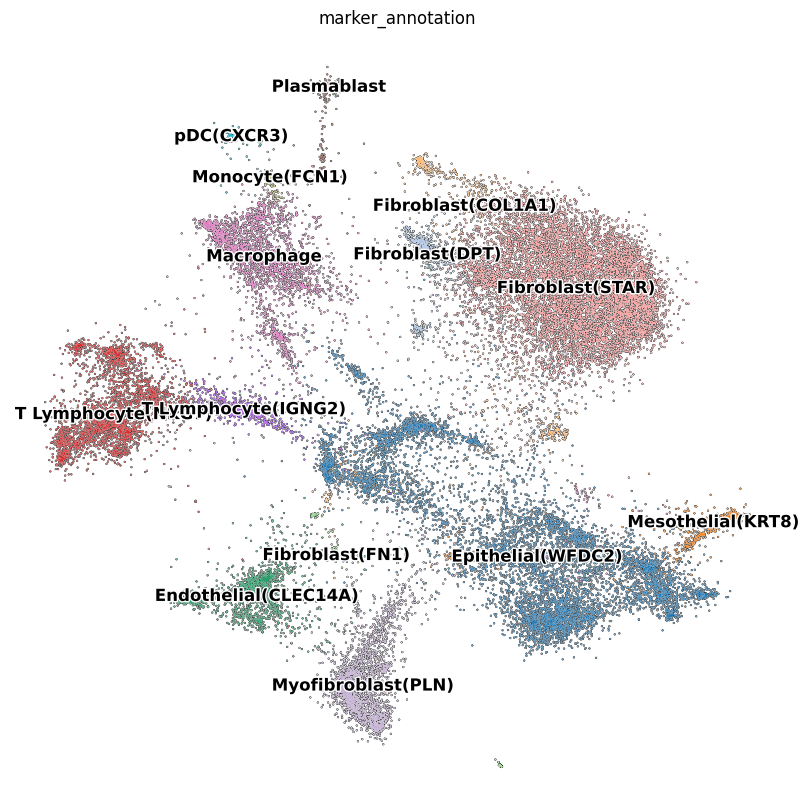

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
  sc.pl.embedding(adata, basis=SCVI_MDE_KEY, color='marker_annotation', add_outline=True, legend_loc='on data',
                legend_fontsize=12, legend_fontoutline=2,frameon=False)

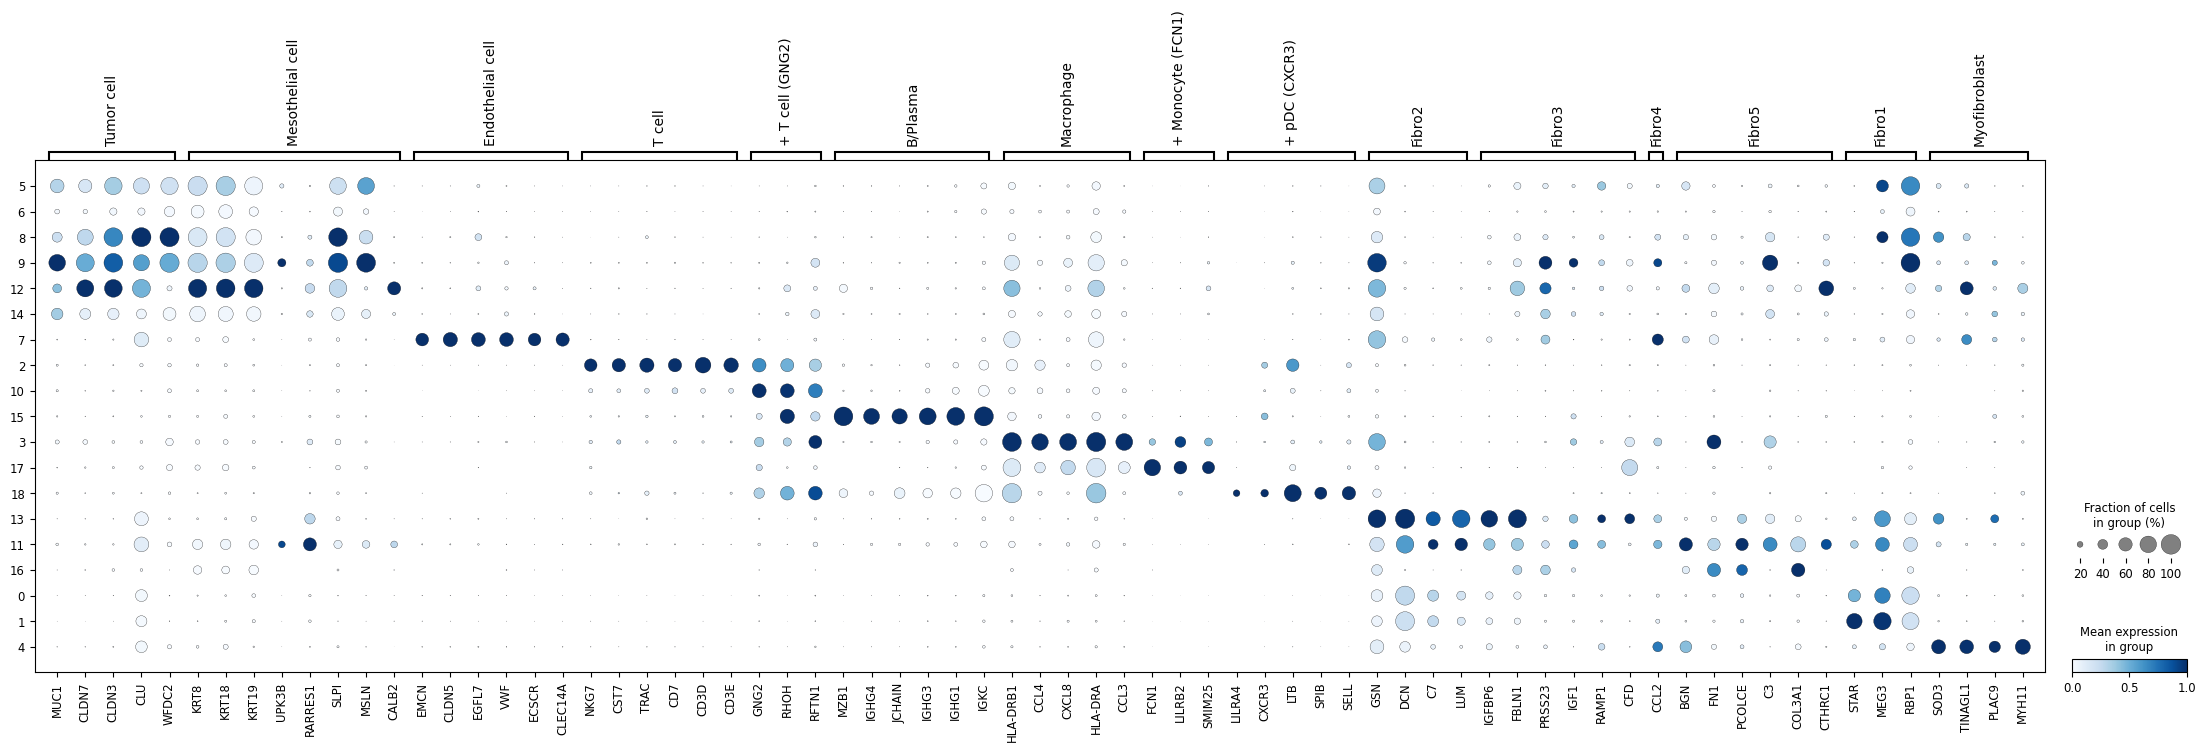

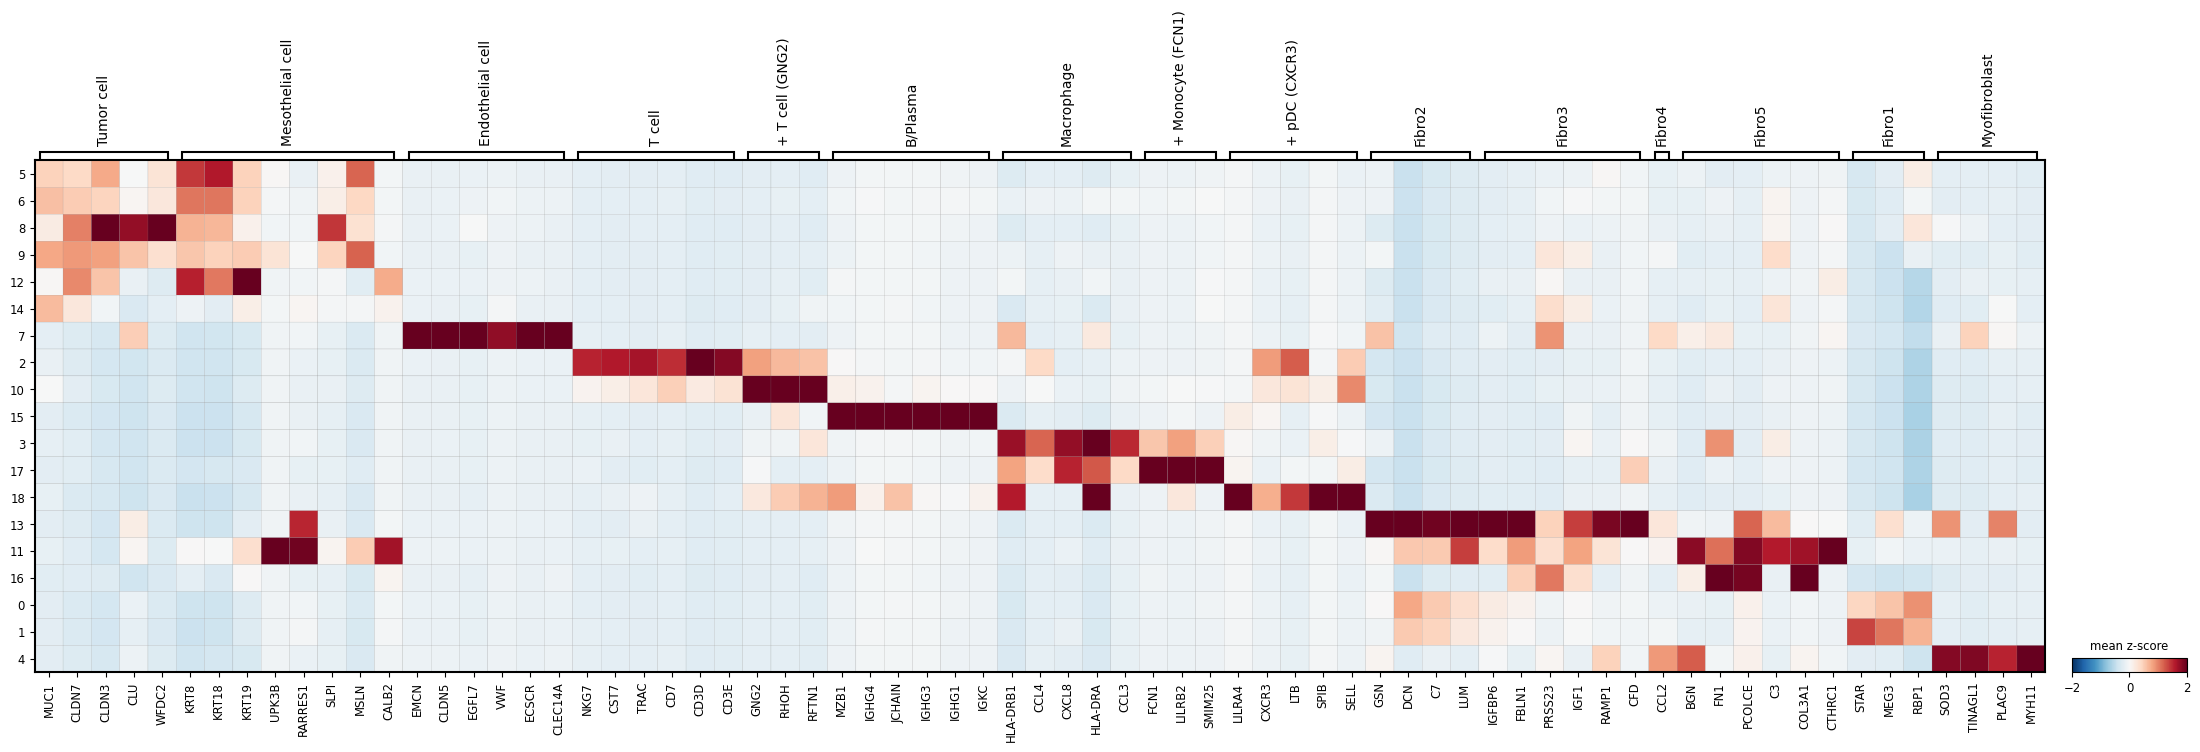

In [ ]:
marker_features = {
     "Tumor cell": ["MUC1", "CLDN7", "CLDN3", "CLU", "WFDC2"],
     "Mesothelial cell": ["KRT8", "KRT18", "KRT19", "UPK3B", "RARRES1", "SLPI", "MSLN", "CALB2"],
     "Endothelial cell": ["EMCN", "CLDN5", "EGFL7", "VWF", "ECSCR", "CLEC14A"],
     "T cell": ["NKG7", "CST7", "TRAC", "CD7", "CD3D", "CD3E"],
     "+ T cell (GNG2)": ["GNG2", "RHOH", "RFTN1"],
     "B/Plasma": ["MZB1", "IGHG4", "JCHAIN", "IGHG3", "IGHG1", "IGKC"],
     "Macrophage": ["HLA-DRB1", "CCL4", "CXCL8", "HLA-DRA", "CCL3"],
     "+ Monocyte (FCN1)": ["FCN1", "LILRB2", "SMIM25"],
     "+ pDC (CXCR3)": ["LILRA4", "CXCR3", "LTB", "SPIB", "SELL"],
     "Fibro2": ["GSN", "DCN", "C7", "LUM"],
     "Fibro3": ["IGFBP6", "FBLN1", "PRSS23", "IGF1", "RAMP1", "CFD"],
     "Fibro4": ["CCL2"],
     "Fibro5": ["BGN", "FN1", "PCOLCE", "C3", "COL3A1", "CTHRC1"],
     "Fibro1": ["STAR", "MEG3", "RBP1"],
     "Myofibroblast": ["SOD3", "TINAGL1", "PLAC9", "MYH11"]
     }

sc.pl.dotplot(
    adata,
    marker_features,
    groupby="leiden_order",
    layer='counts',
    dendrogram=False,
    color_map="Blues",
    swap_axes=False,
    use_raw=False,
    standard_scale="var",
)

sc.pl.matrixplot(
    adata,
    marker_features,
    'leiden_order',
    dendrogram=False,
    layer='counts_scale',
    colorbar_title='mean z-score',
    vmin=-2, vmax=2, cmap='RdBu_r')

In [ ]:
import csv
with open(output_save_dir + 'annotation_dict.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in annotation_dict.items():
       writer.writerow([key, value])

adata.obs.to_csv(output_save_dir + "annotate_metadata.csv")